# Analyzing Passive Acoustic Data with MHKiT

The following example illustrates how to read and analyze some basic parameters for passive acoustics data. Functionality to analyze .wav files recorded using hydrophones has been integrated into MHKiT to support analysis based on the IEC-TS 62600-40 standard.

The standard workflow for passive acoustics analysis is as follows:

1. Import .wav file
2. Calibrate data
3. Calculate spectral density
4. Calculate other parameters

We'll import a couple plotting tools and the acoustics module:

In [1]:
import numpy as np
import matplotlib.dates as mdates

from mhkit import acoustics

### Read in Hydrophone Measurements

All hydrophone .wav files can be read in MHKiT using a base function called `read_hydrophone` from the acoustics.io submodule. Because the sampling frequency is so fast, measurements are stored in the lowest memory format possible and need to be scaled and transformed to return the measurements in units of voltage or pressure.

The `read_hydrophone` function scales and transforms raw measurements given a few input parameters. Most parameters needed to convert the raw data are stored in the native .wav format header blocks, but two, the peak voltage ("peak_V") of the sensor's analog-to-digital converter (ADC) and file "start_time" (usually stored in the filename) are required. 

Two other inputs, the hydrophone "sensitivity" and an amplifier "gain" (typically for custom hydrophone builds) can also be input. If a sensitivity value is provided, the function will convert voltage to pressure; otherwise the sensitivity(ies) can be provided later using a calibration curve. Gain should be provided if the instrument utilizes an amplifier gain, which is then added to the sensitivity.

In [2]:
P = acoustics.io.read_hydrophone(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    peak_V=3, 
    sensitivity=-177, 
    gain=0, 
    start_time="2024-06-01T05:31:14"
)
print(P)

<xarray.DataArray (time: 30720000)> Size: 246MB
array([0.31546374, 0.30229832, 0.32229963, ..., 0.08506887, 0.07291618,
       0.06278893])
Coordinates:
  * time     (time) datetime64[ns] 246MB 2024-06-01T05:31:14 ... 2024-06-01T0...
Attributes:
    units:        Pa
    sensitivity:  1.4125375446227555e-09
    resolution:   9.89e-07
    valid_min:    -2123.837353
    valid_max:    2123.837353
    fs:           512000
    filename:     RBW_6661_20240601_053114.wav


"Smart" hydrophones are those where the hydrophone element, pre-amplifier board, ADC, motherboard and memory card are sold in a single package. Companies that sell these often store metadata in the .wav file header, and MHKiT has a couple of wrapper functions for these hydrophones.

For Ocean Sonics icListen datafiles, only the filename is necessary to provide to return file contents in units of pressure. The stored sensitivity calibration value can be overridden by setting the "sensitivity" input, and to return measurements in units of voltage, set `sensitivity` to None and `use_metadata` to False.

In [3]:
P = acoustics.io.read_iclisten("data/acoustics/RBW_6661_20240601_053114.wav")
V = acoustics.io.read_iclisten(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    sensitivity=None, 
    use_metadata=False
)

For Ocean Instruments Soundtrap datafiles, the filename and sensitivity should be provided to return the measurements in units of pressure. If the hydrophone has been calibrated, set the sensitivity to None to return the measurements in units of voltage.

In [4]:
P = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=-177)
V = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=None)

### Mean Square Sound Pressure Spectral Density

After the .wav file is read in, either in units of pressure or voltage, we calculate the mean square sound pressure spectral density (SPSD) of the timeseries using `sound_pressure_spectral_density`. This splits the timeseries into windows and uses fast Fourier transforms to convert the raw measurements into the frequency domain, with units of $Pa^2/Hz$ or $V^2/Hz$, depending on the input. The function takes the original datafile, the hydrophone's sampling rate, which is stored as an attribute of the measurement timeseries, and a window size in seconds as input.

The IEC-40 considers an acoustic sample to have a length of 1 second, so we'll set the window size as such here.

In [5]:
# Create mean square spectral densities using 1 s windows.
spsd = acoustics.sound_pressure_spectral_density(V, V.fs, window=1)

### Applying Calibration Curves

For conducting scientific-grade analysis, it is critical to use calibration curves to correct the SPSD calculations. Hydrophones should be calibrated (i.e., a sensitivity calibration curve should be generated for a hydrophone) every few years. The IEC-40 asks that a hydrophone be calibrated both before and after the test deployment.

A calibration curve consists of the hydrophone's sensitivity (in units of dB rel $1 V^2/uPa^2$) vs frequency and should be applied to the spectral density we just calculated.

The easiest way to do apply a sensitivity calibration curve in MHKiT is to first copy the calibration data into a CSV file, where the left column contains the calibrated frequencies and the right column contains the sensitivity values. Here we use the function in the following codeblock to read in a CSV file I created with the column headers "Frequency" and "Analog Sensitivity".

In [6]:
import pandas as pd

def read_calibration_file(filename):
    calibration = pd.read_csv(filename, sep=",")
    calibration.index = calibration["Frequency"]
    calibration = calibration.to_xarray()
    return calibration["Analog Sensitivity"]

sensitivity_curve = read_calibration_file("data/acoustics/6247_calibration.csv")
print(sensitivity_curve)

<xarray.DataArray 'Analog Sensitivity' (Frequency: 40)> Size: 320B
array([-223.49, -220.8 , -218.13, -215.41, -212.68, -209.91, -207.12,
       -204.29, -201.45, -198.58, -195.69, -192.79, -189.85, -186.9 ,
       -183.93, -180.93, -177.92, -174.97, -172.16, -169.61, -167.69,
       -166.52, -165.96, -165.81, -165.85, -165.95, -166.05, -166.13,
       -166.2 , -166.25, -166.28, -166.29, -166.29, -166.27, -166.24,
       -166.17, -166.03, -165.79, -165.47, -164.87])
Coordinates:
  * Frequency  (Frequency) float64 320B 1.0 1.183 1.399 ... 500.3 591.8 700.0


Once we have the calibration data in an xarray DataArray, we can apply that to the SPSD using the `apply_calibration` function. Calibration curves typically do not cover the entire range of the hydrophone, so this function will linearly interpolate the missing values. A fill_value can be provided to extrapolate outside of the calibrated frequencies.

In [7]:
# Use last value in calibration curve for higher frequencies
fill_Sf = sensitivity_curve[-1].values
spsd = acoustics.apply_calibration(spsd, sensitivity_curve, fill_value=fill_Sf)

### Mean Square Sound Pressure Spectral Density Level

We can use the function `sound_pressure_spectral_density_level` to calculate the mean square sound pressure spectral density levels (SPSDLs) from the calibrated SPSD. This function converts absolute pressure into relative pressure in log-space, the traditional means with which we measure sound, in units of decibels relative to 1 uPa (dB rel 1 uPa), the standard for underwater sound. 
    
Sidenote: Sound in air is measured in decibels relative to 20 uPa, the minimum pressure level humans can hear. To convert between dB rel 1 uPa and dB rel 20 uPa, one simply needs to subtract 26 dB from the dB rel 1 uPa value.

In [8]:
spsdl = acoustics.sound_pressure_spectral_density_level(spsd)

Now that the SPSDL is calculated, we can create spectograms, or waterfall plots, using the `plot_spectogram` function in the graphics submodule. While spectograms aren't required by the IEC-40, they are useful to do quality control so we can avoid using contaminated soundbytes in further analysis (like the boat noise shown in this one).

To do this, we'll give the function the minimum and maximum frequencies to plot, as well as keyword arguments supplied to the matplotlib pcolormesh function. For these measurements, we're setting fmin = 10 Hz, the minimum specified by the IEC-40, and fmax = 48,000 Hz, the Nyquist frequency for these data. 

Note, the IEC-40 requires a maximum frequency of 100,000 Hz, so a hydrophone capable of sampling faster than 200,000 Hz should be used for IEC testing.

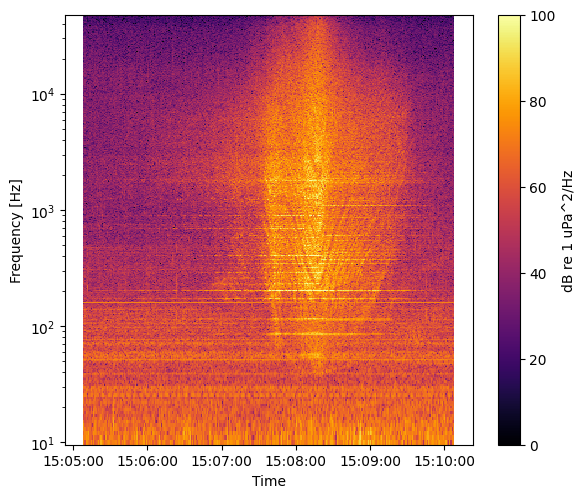

In [9]:
fmin = 10
fmax = 48000

# Create high resolution spectogram
fig, ax = acoustics.graphics.plot_spectogram(
    spsdl, fmin, fmax, kwargs={"cmap": "inferno", "vmin": 0, "vmax": 100}
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))


If you see something interesting in the spectogram, the next step you should do is listen to the .wav file. This can tell you a lot about what you're looking at. If you listen to this file, you'll hear the boat cruising by around 3 minutes in.

Some audio players aren't able to play some hydrophone recodings (i.e. icListens), so be sure to try multiple if you can't hear anything in one particular player. Higher-end hydrophones tend to user higher ADC peak voltages, which will translate to quieter audio tracks. You can use the `export_audio` file in the io submodule to rescale these audio tracks and increase the gain if need be.

In [10]:
# Uncomment to save new file
filename = "sound1.wav"
#acoustics.io.export_audio(filename, P, gain=1)

### Window Averaging

The IEC-40 requires a few aggregate statistics for characterizing the sound of marine energy devices. For the first, the IEC-40 asks for plots showing the 25%, 50%, and 75% quantiles of the SPSDL during specific marine energy device states. For current energy devices, the IEC-40 requires 10 SPSDL samples at a series of turbine states (braked, freewheel, 25% power, 50% power, 75% power, 100% power). For wave energy devices, the spec requires 30 SPSDL samples in each wave height and period bin observed.

In the following code block, we'll take our 5 minutes of measurements, `time_average` them into 30 second intervals, and find the median, 25% and 75% quantiles of each interval. For the IEC-40, the sets 10 or 30 samples can either be continuous timeseries or pieced together from individual 1 s measurements. For this example notebook we'll keep it simple and just use the first 30 s interval.

In [11]:
# Time average into 30 s windows
window = 30
spsdl_50 = acoustics.time_average(spsdl, window, method="median")
spsdl_25 = acoustics.time_average(spsdl, window, method="quantile", method_arg=0.25)
spsdl_75 = acoustics.time_average(spsdl, window, method="quantile", method_arg=0.75)

We can then using the `plot_spectra` function in the graphics submodule to plot the median and quantiles of the first 30 s window.

Text(0.5, 1.0, 'Median and Quantile Sound Pressure Spectral Density Level')

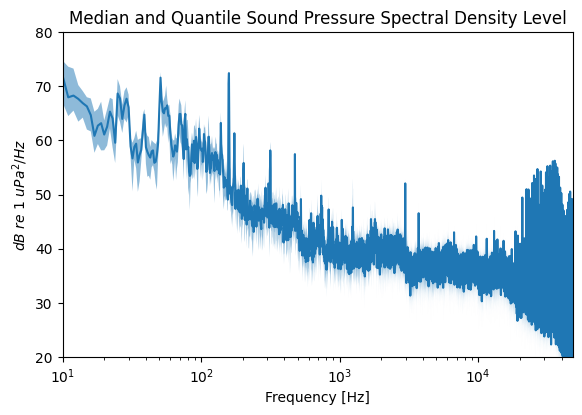

In [12]:
# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_50[0], fmin, fmax)
ax.fill_between(
    spsdl_50["freq"],
    spsdl_25[0],
    spsdl_75[0],
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set_ylim(20, 80)
ax.set_title("Median and Quantile Sound Pressure Spectral Density Level")

### Sound Pressure Level

The next two requirements from the IEC-40 are calculations of sound pressure level (SPL). We'll first calculate the SPL over the full frequency range of the turbine and/or hydrophone. The IEC-40 asks that the range be set from 10 to 100,000 Hz, though the lower limit can be increased due to flow noise or low frequency signal loss due to shallow water. 

#### Shallow water cutoff frequency
Low frequency sound is absorbed into the seabed in shallow water depths. We can use the function `minimum_frequency` to get an approximation of what our minimum frequency should be. This approximation uses the water depth, estimates of the in-water sound speed and sea/riverbed sound speed to determine what the cutoff frequency will be. The difficult part with this approximation is figuring out the speed of sound in the bed material, which generally ranges from 1450-1800 m/s. 

This function should only be used as a rough approximation and sanity check if significant attenuation is seen at various low frequencies and harmonics.

In [13]:
depths = np.array([1, 5, 10, 20, 40, 80])
fmin = acoustics.minimum_frequency(water_depth=depths, c=1500, c_seabed=1700)

print("Depth [m], Freq [Hz]")
for d, f in zip(depths, fmin):
    print(f"{d}, {f:0.1f}")

Depth [m], Freq [Hz]
1, 796.9
5, 159.4
10, 79.7
20, 39.8
40, 19.9
80, 10.0


Though the IEC-40 says we should default to a minimum frequency of 10 Hz, as you can see above, unless we're measuring from a depth of around 80 +/- 10 m, our minimum frequency should be higher. One can play around with the bed soundspeed to see how these change with varying bed densities/compositions.

#### Flow Noise
Flow noise, or psuedo-sound, is the other reason to increase the minimum frequency of our SPL measurements. Flow noise is caused by one of three things: turbulence advected past the hydrophone element, turbulence caused by the hydrophone element, and the sensitivity of the hydrophone element to temperature inhomogeneities in the advected flow. Flow noise is most noticeably apparent when flow speeds increase above 0.5 m/s, seen in spectograms as a logarithmic increase in pressure with decreasing frequency.

The particular data shown here was measured in around 8-10 m of water, and a mix of mild flow noise below 20 Hz and low frequency attenutation below ~50 Hz can be seen in the spectogram. We'll again use the Nyquist frequency of 48,000 Hz.

In [14]:
# Sound pressure level
fmin = 50
fmax = 48000

spl = acoustics.sound_pressure_level(spsd, fmin, fmax)
spl_q50 = acoustics.time_average(spl, window, method="median")
print(f"spl_median: {spl_q50[0].values:0.2f}")

spl_median: 86.02


So our median SPL for this overall frequency band is 98.5 dB rel 1 uPa.

### Decidecade Sound Pressure Levels

The last stat that IEC-40 requests are the decidecade SPLs. Note that the IEC-40 incorrectly labels these as synonymous with the third-octave SPLs, following the relevant (and also incorrect) ANSI specifications. 

To explain, an octave is a frequency band where the upper frequency is double (2^1) that of the lower frequency. The one-third octave is a frequency band where the upper frequency is 2^(1/3) times the lower frequency. The decidecade is a frequency band with a bandwidth of 2^(1/10), which means it's the tenth octave, not the third. Wherever the IEC-40 says third octave they actually mean the decidecade band.

We can calculate the SPL in each decidecade band using the function `decidecade_sound_pressure_level`. This function uses the same calculation as `sound_pressure_level` above and run it on each tenth octave band. Note that the SPL in smaller frequency bands will be smaller than the SPL in larger ones.

[Text(0.5, 0, 'Frequency [Hz]'), Text(0, 0.5, 'Decidecade SPL [dB re 1 uPa]')]

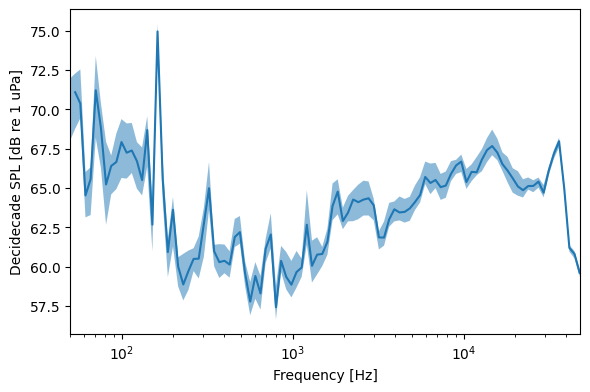

In [15]:
# Decidecade octave sound pressure level (also interquartile)
spl10 = acoustics.decidecade_sound_pressure_level(spsd, fmin, fmax)

# Time average into 30 s windows
window = 30
spl10_q50 = acoustics.time_average(spl10, window, method="median")
spl10_q25 = acoustics.time_average(spl10, window, method="quantile", method_arg=0.25)
spl10_q75 = acoustics.time_average(spl10, window, method="quantile", method_arg=0.75)

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spl10_q50[0], fmin, fmax)
ax.fill_between(
    spl10_q50["freq_bins"],
    spl10_q25[0],
    spl10_q75[0],
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set(xlabel="Frequency [Hz]", ylabel="Decidecade SPL [dB re 1 uPa]")

### Third Octave Sound Pressure Level

Since you're now curious, you can also calculate the 1/3 octave SPLs using `third_octave_sound_pressure_level`. Third octaves are often measured because the human ear appears to have evolved to filter sound at this bandwidth. 

[Text(0, 0.5, 'Third Octave SPL [dB re 1 uPa]')]

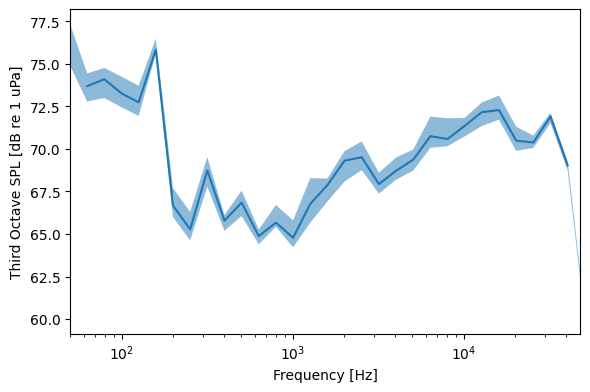

In [16]:
# Median third octave sound pressure level
spl3 = acoustics.third_octave_sound_pressure_level(spsd, fmin, fmax)

# Time average into 30 s windows
window = 30
spl3_q50 = acoustics.time_average(spl3, window, method="median")
spl3_q25 = acoustics.time_average(spl3, window, method="quantile", method_arg=0.25)
spl3_q75 = acoustics.time_average(spl3, window, method="quantile", method_arg=0.75)

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spl3_q50[0], fmin, fmax)
ax.fill_between(
    spl3_q50["freq_bins"],
    spl3_q25[0],
    spl3_q75[0],
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set(ylabel="Third Octave SPL [dB re 1 uPa]")